# Regresión Logística: Ejemplo 2


In [ ]:
# Solo si se corre en Google Colab
!pip install pyspark 

     |████████████████████████████████| 212.4MB 71kB/s 
     |████████████████████████████████| 204kB 16.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=ead3b8ea16d5c64057e22420b792b2e222fe1e4559ce1e5ab7b705b106fdc629
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression

spark = SparkSession.builder.appName('EjemploRegLog2').getOrCreate()

## 1. Lectura de Datos

Se utilizará los datos del Titanic. Estos datos tienen la siguiente estructura:
* Sobrevive: 0 = No, 1 = Sí
* Clase: clase del pasajero (1 = 1a, 2 = 2da, 3 = 3a)
* Genero
* Sibsp: Número de hermanos + esposo(a) a bordo
* Parch: Número de padres + hijos a bordo
* Boleto: Número de boleto
* Precio: Precio del boleto
* Cabina
* PuertoEmb: puerto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton)

In [ ]:
df = spark.read.csv('/content/titanic.csv', inferSchema=True, header=True)

df.show(5)

+----------+---------+-----+--------------------+------+----+-----+-----+----------------+-------+------+---------+
|IDpasajero|Sobrevive|Clase|              Nombre|Genero|Edad|SibSp|ParCh|          Boleto| Precio|Cabina|PuertoEmb|
+----------+---------+-----+--------------------+------+----+-----+-----+----------------+-------+------+---------+
|         1|        0|    3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|  null|        S|
|         2|        1|    1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|   C85|        C|
|         3|        1|    3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|  null|        S|
|         4|        1|    1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|  C123|        S|
|         5|        0|    3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|  null|        S|
+----------+---------+-----+--------------------+------+----+-----+-----

In [ ]:
# Esquema
df.printSchema()

# Nombres de las columnas
# df.columns

root
 |-- IDpasajero: integer (nullable = true)
 |-- Sobrevive: integer (nullable = true)
 |-- Clase: integer (nullable = true)
 |-- Nombre: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Edad: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- ParCh: integer (nullable = true)
 |-- Boleto: string (nullable = true)
 |-- Precio: double (nullable = true)
 |-- Cabina: string (nullable = true)
 |-- PuertoEmb: string (nullable = true)



## 2. Pre-procesamiento

In [ ]:
# Seleccionar solo algunas columnas
df = df.select(['Sobrevive', 'Clase', 'Genero', 'Edad', 'SibSp', 
                 'ParCh', 'Precio', 'PuertoEmb'])

# Eliminar filas con datos faltantes
df = df.na.drop()

# Separación de datos en entrenamiento y prueba
df_train, df_test = df.randomSplit([0.7,0.3])

# Mostrar algunos datos de entrenamiento
df_train.show(5)

+---------+-----+------+----+-----+-----+-------+---------+
|Sobrevive|Clase|Genero|Edad|SibSp|ParCh| Precio|PuertoEmb|
+---------+-----+------+----+-----+-----+-------+---------+
|        0|    1|female|25.0|    1|    2| 151.55|        S|
|        0|    1|  male|18.0|    1|    0|  108.9|        C|
|        0|    1|  male|19.0|    1|    0|   53.1|        S|
|        0|    1|  male|19.0|    3|    2|  263.0|        S|
|        0|    1|  male|21.0|    0|    1|77.2875|        S|
+---------+-----+------+----+-----+-----+-------+---------+
only showing top 5 rows



### Conversión de datos categóricos en one-hot encoding

In [ ]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [ ]:
# C=0, S=1, Q=2
#             C   S   Q
# One hot:  [ 1 , 0 , 0 ]     C
#           [ 0 , 1 , 0 ]     S
#           [ 0,  0,  1 ]     Q

# Asignar números a "género"
genero_indexer = StringIndexer(inputCol='Genero', outputCol='GeneroIndex')
# Convertir cada número en "one-hot encoding"
genero_onehot = OneHotEncoder(inputCol='GeneroIndex',outputCol='GeneroVec')

# Convertir valores de puerto en "número" y luego en "one-hot encoding"
puerto_indexer = StringIndexer(inputCol='PuertoEmb',outputCol='PuertoIndex')
puerto_onehot = OneHotEncoder(inputCol='PuertoIndex',outputCol='PuertoVec')

In [ ]:
# Vector que agrupa todos los atributos
vassembler = VectorAssembler(inputCols=['Clase', 'GeneroVec', 'PuertoVec', 'Edad', 
                                        'SibSp', 'ParCh', 'Precio'],
                             outputCol='atributos')

## 3. Creación de un pipeline y Entrenamiento

Un pipeline genera etapas que serán aplicadas a todos los datos (como un flujo de operaciones)

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
# Modelo de regresión logística
modelo_reglog = LogisticRegression(featuresCol='atributos', labelCol='Sobrevive', 
                                   predictionCol='Prediccion')

# Aplicar las etapas (pipeline)
pipeline = Pipeline(stages=[genero_indexer, genero_onehot,
                            puerto_indexer, puerto_onehot,
                            vassembler, modelo_reglog])

In [ ]:
# Entrenamiento del modelo (usando todas las etapas anteriores)
modelo = pipeline.fit(df_train)

In [ ]:
# Etapas del pipeline
modelo.stages

[StringIndexerModel: uid=StringIndexer_806f54665f40, handleInvalid=error,
 OneHotEncoderModel: uid=OneHotEncoder_8aa80fa6c6de, dropLast=true, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_ce2f56805269, handleInvalid=error,
 OneHotEncoderModel: uid=OneHotEncoder_9f5e37c450c0, dropLast=true, handleInvalid=error,
 VectorAssembler_164be0c93651,
 LogisticRegressionModel: uid=LogisticRegression_bb8c2dc8c921, numClasses=2, numFeatures=8]

### Métricas para el entrenamiento

In [ ]:
# Recuperación del modelo de regresión logística
reglog = modelo.stages[5]

In [1]:
reglog

NameError: ignored

In [ ]:
# Predicciones para el conjunto de entrenamiento
reglog.summary.predictions.show(5)

+---------+-----+------+----+-----+-----+-------+---------+-----------+-------------+-----------+-------------+--------------------+--------------------+--------------------+----------+
|Sobrevive|Clase|Genero|Edad|SibSp|ParCh| Precio|PuertoEmb|GeneroIndex|    GeneroVec|PuertoIndex|    PuertoVec|           atributos|       rawPrediction|         probability|Prediccion|
+---------+-----+------+----+-----+-----+-------+---------+-----------+-------------+-----------+-------------+--------------------+--------------------+--------------------+----------+
|      0.0|    1|female|25.0|    1|    2| 151.55|        S|        1.0|    (1,[],[])|        0.0|(2,[0],[1.0])|[1.0,0.0,1.0,0.0,...|[-2.9230123838006...|[0.05102763236303...|       1.0|
|      0.0|    1|  male|18.0|    1|    0|  108.9|        C|        0.0|(1,[0],[1.0])|        1.0|(2,[1],[1.0])|[1.0,1.0,0.0,1.0,...|[-1.1064416296970...|[0.24853487378444...|       1.0|
|      0.0|    1|  male|19.0|    1|    0|   53.1|        S|        0.0

In [ ]:
# True Positives (por etiqueta)
print("TP para prueba:", reglog.summary.truePositiveRateByLabel)     

# False Positives (por etiqueta)
print("FP para prueba:", reglog.summary.falsePositiveRateByLabel)

TP para prueba: [0.8631578947368421, 0.7391304347826086]
FP para prueba: [0.2608695652173913, 0.1368421052631579]


In [ ]:
# Métricas para el conjunto de entrenamiento
accuracy = reglog.summary.accuracy
AUC = reglog.summary.areaUnderROC

print("Exactitud en el conjunto de entrenamiento:", accuracy)
print("Área bajo la curva ROC en el conjunto de entrenamiento:", AUC)

Exactitud en el conjunto de entrenamiento: 0.8109756097560976
Área bajo la curva ROC en el conjunto de entrenamiento: 0.8662598525298751


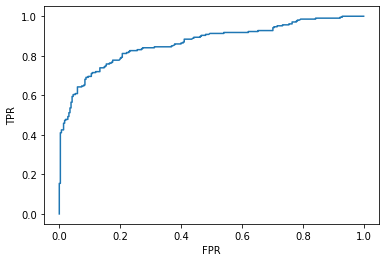

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Curva ROC
roc = reglog.summary.roc.collect()
n = len(roc); FPR = np.zeros(n); TPR = np.zeros(n)
for idx, elem in enumerate(roc):
  FPR[idx] = elem.FPR
  TPR[idx] = elem.TPR
plt.plot(FPR, TPR)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

## 4. Predicción y Evaluación

In [ ]:
# Aplicar el modelo a los datos de prueba (test)
resultado = modelo.transform(df_test)

# Resultados
resultado.select('Sobrevive','Prediccion').show(8)

+---------+----------+
|Sobrevive|Prediccion|
+---------+----------+
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       0.0|
+---------+----------+
only showing top 8 rows



In [ ]:
type(resultado)

pyspark.sql.dataframe.DataFrame

In [ ]:
from pyspark.ml.evaluation import (BinaryClassificationEvaluator, 
                                   MulticlassClassificationEvaluator)

In [ ]:
evaluador1 = BinaryClassificationEvaluator(rawPredictionCol='Prediccion', 
                                           labelCol='Sobrevive',
                                           metricName='areaUnderROC')
AUC = evaluador1.evaluate(resultado)
print("Área bajo la curva ROC en el conjunto de prueba:", AUC)

Área bajo la curva ROC en el conjunto de prueba: 0.7768451905142553


In [ ]:
# Evaluador de la exactitud (accuracy)
evaluador2 = MulticlassClassificationEvaluator(predictionCol='Prediccion', 
                                               labelCol='Sobrevive',
                                               metricName='accuracy')
exactitud = evaluador2.evaluate(resultado)
print("Exactitud en el conjunto de prueba:", exactitud)

Exactitud en el conjunto de prueba: 0.7863636363636364
